In [1]:
import numpy as np
import pandas as pd

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore') 
#warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

import eli5
from eli5.sklearn import PermutationImportance

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('Gold1.csv')

In [3]:
df

,datetime,US_interest_rate,Gold_Price,Gold_Change,Silver_Price,Silver_Change,US_10_year_rate,10_year_rate_Change,DollarIndex,DollarIndex_Change,USD_KRW_Price,USD_KRW_Change
0,2021-04-26,1.1,1776.80,0.12,25.990,-0.02,1.5648,0.12,90.757,-0.09,1115.13,0.04
1,2021-04-25,1.1,1774.65,-0.13,25.995,-0.31,1.5630,0.22,90.839,-0.53,1115.13,0.04
2,2021-04-23,1.1,1777.00,-0.24,26.075,-0.40,1.5595,1.16,90.839,-0.53,1114.72,-0.36
3,2021-04-22,1.1,1781.20,-0.62,26.180,-1.47,1.5416,-1.12,91.321,0.21,1118.79,0.22
4,2021-04-21,1.1,1792.30,0.84,26.570,2.83,1.5590,-0.45,91.129,-0.11,1116.35,-0.08
...,...,...,...,...,...,...,...,...,...,...,...,...
7964,1990-01-08,8.1,403.00,-0.81,5.244,-1.39,8.0260,1.17,92.800,-0.88,683.60,-0.01
7965,1990-01-05,8.1,406.30,1.93,5.318,0.95,8.0260,0.00,93.620,0.49,683.70,-0.07
7966,1990-01-04,8.1,398.60,1.17,5.268,2.27,8.0260,0.00,93.160,-2.16,684.20,0.10
7967,1990-01-03,8.1,394.00,-1.40,5.151,-0.62,8.0260,0.00,95.220,0.02,683.50,0.31


In [4]:
df = df.sort_values(by = 'datetime')
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y/%m/%d")

df.index = df['datetime']

df = df.drop('datetime', axis = 1)

feature = ['Gold_Price','DollarIndex','US_10_year_rate','US_interest_rate']
target = ['Gold_Price']

df = df[feature]


In [5]:
df.isnull().sum()

Gold_Price          0
DollarIndex         0
US_10_year_rate     0
US_interest_rate    0
dtype: int64

In [6]:
# 기준 모델 만들기
predict = df['Gold_Price'].mean()

In [7]:
predict

805.5120617392424

In [8]:
errors = predict - df['Gold_Price']
## mean_absolute_error(MAE), error에 절대값을 취한 후 평균을 계산합니다.
mean_absolute_error = errors.abs().mean()

In [9]:
mean_absolute_error

479.71154038563964

In [10]:
df['Gold_Price']

datetime
1990-01-02     399.60
1990-01-03     394.00
1990-01-04     398.60
1990-01-05     406.30
1990-01-08     403.00
               ...   
2021-04-21    1792.30
2021-04-22    1781.20
2021-04-23    1777.00
2021-04-25    1774.65
2021-04-26    1776.80
Name: Gold_Price, Length: 7969, dtype: float64

In [11]:
predict = [predict] * len(df)

In [12]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(df['Gold_Price'], predict)**0.5
print(RMSE)

519.9933607756207


In [13]:
from sklearn.metrics import r2_score
print(r2_score(df['Gold_Price'],predict))

0.0


# 기본모델 RMSE = 519.9933607756207

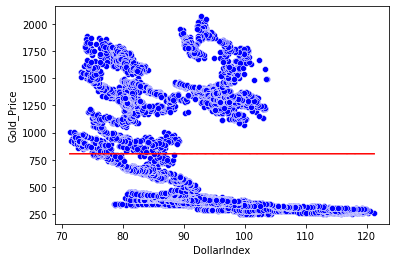

In [14]:
x = df['DollarIndex']
y = df['Gold_Price']

predict = df['Gold_Price'].mean()
errors = predict - df['Gold_Price']
mean_absolute_error = errors.abs().mean()

sns.lineplot(x=x, y=predict, color='red')
sns.scatterplot(x=x, y=y, color='blue');

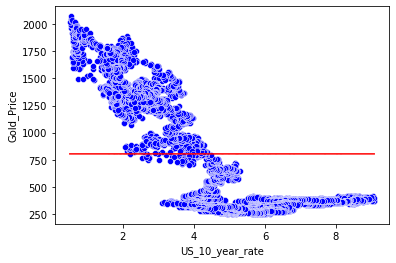

In [15]:
x = df['US_10_year_rate']
y = df['Gold_Price']

predict = df['Gold_Price'].mean()
errors = predict - df['Gold_Price']
mean_absolute_error = errors.abs().mean()

sns.lineplot(x=x, y=predict, color='red')
sns.scatterplot(x=x, y=y, color='blue');

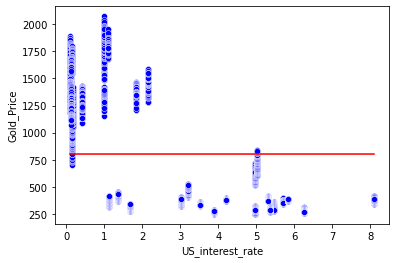

In [16]:
x = df['US_interest_rate']
y = df['Gold_Price']

predict = df['Gold_Price'].mean()
errors = predict - df['Gold_Price']
mean_absolute_error = errors.abs().mean()

sns.lineplot(x=x, y=predict, color='red')
sns.scatterplot(x=x, y=y, color='blue');

In [17]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size = 0.8, shuffle=False)
train, val = train_test_split(train, train_size = 0.8, shuffle=False)

In [18]:
target = 'Gold_Price'

features = train.drop(columns=[target]).columns

y_train = train[target]
X_train = train[features]
y_val = val[target]
X_val = val[features]
y_test = test[target]
X_test = test[features]

In [19]:
X_test

,DollarIndex,US_10_year_rate,US_interest_rate
datetime,,,
2015-04-16,97.614,1.8950,0.13
2015-04-17,97.707,1.8650,0.13
2015-04-20,98.160,1.8860,0.13
2015-04-21,98.205,1.9110,0.13
2015-04-22,98.138,1.9820,0.13
...,...,...,...
2021-04-21,91.129,1.5590,1.10
2021-04-22,91.321,1.5416,1.10
2021-04-23,90.839,1.5595,1.10


In [20]:
from scipy.stats import randint, uniform

pipe = make_pipeline(
    RandomForestRegressor(random_state=2)
)

dists = {   
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1) # max_features
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [21]:
print('훈련 정확도: ', clf.score(X_train, y_train))
print('검증 정확도: ', clf.score(X_val, y_val))

훈련 정확도:  -4.35936373108095
검증 정확도:  -543.3913096843605


In [22]:
y_pred_train = clf.predict(X_train)
y_pred_val = clf.predict(X_val)
y_pred_test = clf.predict(X_test)

In [23]:
from sklearn.metrics import r2_score
print(r2_score(y_train,y_pred_train))
print(r2_score(y_val,y_pred_val))
print(r2_score(y_test,y_pred_test))

0.9985770421676688
-9.369636716574862
-20.234026659547457


In [24]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_test, y_pred_test)**0.5
print(RMSE)

980.8352295740506


In [25]:
y = y_test.tolist()

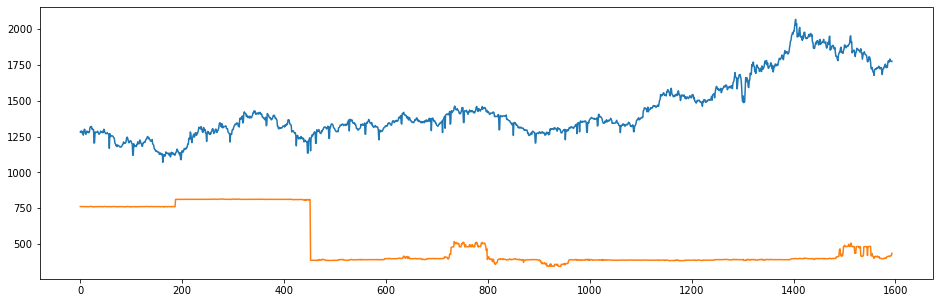

In [26]:
# 파란색이 현재 이후 예측 값 2022 4월 까지 그림

fig, ax = plt.subplots(figsize=(16,5))
plt.plot(y)
plt.plot(y_pred_test)
plt.show()

In [27]:
pipe = Pipeline([
    ('xgb',XGBRegressor(eval_metric = 'rmse'
                  , random_state=2
                  , n_jobs=-1
                 ))])

param_grid = {'xgb__n_estimators': [100, 200, 300, 500, 600, 700, 800], 
              'xgb__learning_rate': [0.01, 0.05, 0.1, 0.15,  0.2],
              'xgb__max_depth' : [1, 3, 5, 7, 10],
              'xgb__sub_sample' : [ 0.2, 0.5, 0.8, 1],
              'xgb__colsample_bytree': [0.2, 0.5, 0.8, 1]}

randomizedsearch = RandomizedSearchCV(pipe, param_grid, cv=4, scoring ='neg_root_mean_squared_error', n_jobs=-1, verbose=4, random_state = 42)
randomizedsearch.fit(X_train, y_train)

print('Best Parameter :', randomizedsearch.best_params_)
print('Best Score : ', -(randomizedsearch.best_score_))

model = randomizedsearch.best_estimator_
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# print('\n훈련 RMSE: ', sqrt(mean_squared_error(y_train, y_pred_train)))
print('검증 RMSE: ', np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('검증 RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred_val)))
print('검증 RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred_test)))

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[04:55:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "sub_sample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Best Parameter : {'xgb__sub_sample': 0.8, 'xgb__n_estimators': 300, 'xgb__max_depth': 1, 'xgb__learning_rate': 0.15, 'xgb__colsample_bytree': 0.5}
Best Score :  211.52429567257235
검증 RMSE:  56.499482340193595
검증 RMSE:  535.577896825764
검증 RMSE:  923.4249621108996


In [28]:
from sklearn.metrics import r2_score
print(r2_score(y_train,y_pred_train))
print(r2_score(y_val,y_pred_val))
print(r2_score(y_test,y_pred_test))

0.9275912764812224
-7.885099467693337
-17.821033424997985


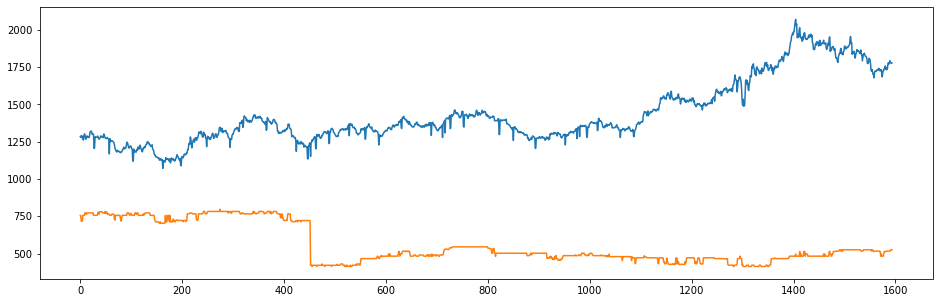

In [29]:
# 파란색이 현재 이후 예측 값 2022 4월 까지 그림
y = y_test.tolist()
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(y)
plt.plot(y_pred_test)
plt.show()

In [30]:
y_test

datetime
2015-04-16    1283.00
2015-04-17    1288.10
2015-04-20    1279.30
2015-04-21    1289.10
2015-04-22    1274.70
               ...   
2021-04-21    1792.30
2021-04-22    1781.20
2021-04-23    1777.00
2021-04-25    1774.65
2021-04-26    1776.80
Name: Gold_Price, Length: 1594, dtype: float64

In [31]:
y_pred_test

array([755.00665, 755.00665, 717.0318 , ..., 525.59674, 525.59674,
       525.59674], dtype=float32)

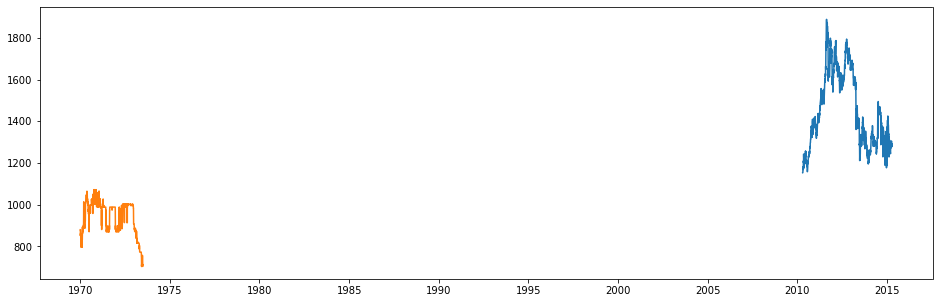

In [32]:
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(y_val)
plt.plot(y_pred_val)
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_test, y_pred_test)**0.5
print(RMSE)

923.4249621108996


In [34]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_val, y_pred_val)**0.5
print(RMSE)

535.577896825764


In [35]:
df

,Gold_Price,DollarIndex,US_10_year_rate,US_interest_rate
datetime,,,,
1990-01-02,399.60,95.200,8.0260,8.1
1990-01-03,394.00,95.220,8.0260,8.1
1990-01-04,398.60,93.160,8.0260,8.1
1990-01-05,406.30,93.620,8.0260,8.1
1990-01-08,403.00,92.800,8.0260,8.1
...,...,...,...,...
2021-04-21,1792.30,91.129,1.5590,1.1
2021-04-22,1781.20,91.321,1.5416,1.1
2021-04-23,1777.00,90.839,1.5595,1.1


In [36]:
y = df['Gold_Price'].tolist()

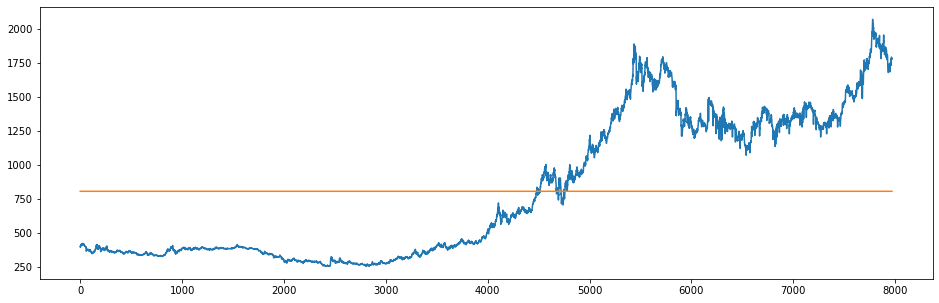

In [37]:
# 1990년 이후 금 시세 + 평균
predict = [predict] * len(df)
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(y)
plt.plot(predict)
plt.show()